In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim #optimization algorithms

from torchvision import datasets # contains datasets with almost similar API
from torchvision import transforms # contains common image transformations

import os
import random
from torch.optim.lr_scheduler import StepLR

In [ ]:
PATH = '/content/drive/My Drive/DL/HW2/train'
classes = os.walk(PATH).__next__()[1]
train_imagepaths= list()
test_imagepaths = list()

selected_classes = ['n02950826', 'n02963159', 'n04008634', 'n03355925', 'n03980874']
selected_train_samples = []
selected_test_samples = []

for c in classes:
  new_path = PATH+"/"+c+"/images/"
  images = os.walk(new_path).__next__()[2]
  c_images = []
  for img in images:
    c_images.append(new_path+ img)
  random.shuffle(c_images)
  if c in selected_classes:
    selected_train_samples.append(c_images[55])
    selected_test_samples.append(c_images[5])
  train_imagepaths.extend(c_images[50:])
  test_imagepaths.extend(c_images[:50])

random.shuffle(train_imagepaths)
random.shuffle(test_imagepaths)

In [ ]:
selected_test_samples

['/content/drive/My Drive/DL/HW2/train/n02950826/images/n02950826_46.JPEG',
 '/content/drive/My Drive/DL/HW2/train/n02963159/images/n02963159_201.JPEG',
 '/content/drive/My Drive/DL/HW2/train/n04008634/images/n04008634_49.JPEG',
 '/content/drive/My Drive/DL/HW2/train/n03355925/images/n03355925_37.JPEG',
 '/content/drive/My Drive/DL/HW2/train/n03980874/images/n03980874_178.JPEG']

In [ ]:
print(len(train_imagepaths))

9000


In [ ]:
from torchvision.transforms.transforms import Grayscale
import torch
import torchvision as tv
from torchvision import transforms
from PIL import Image


transform1 = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224),
                      transforms.ToTensor() ])
# , transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

def read_image(path):
  convert_tensor = transforms.ToTensor()
  image = []
  img = Image.open(path)
  temp = img.copy()
  temp = convert_tensor(temp)
  if temp.shape[0] == 1:
    img = img.convert('RGB')
  img = transform1(img)
  img = torch.unsqueeze(img, 0)
 
  return img


In [ ]:
def plot_image(img):
  transform = transforms.ToPILImage()
  img = transform(img)
  plt.imshow(img)
print(len(selected_train_samples))


5


In [ ]:

import torchvision.models as models
AlexNet = models.alexnet(pretrained=True)
AlexNet.eval()

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
class Conv2_Decoder(nn.Module):
  def __init__(self):
    self.learning_rate = 0.03
    self.test_loss_epoch = []
    self.train_loss_epoch = []
    super(Conv2_Decoder, self).__init__()

    features = list(AlexNet.features)[:6]
    self.AlexNet_Conv2 = nn.ModuleList(features).eval()
    self.conv1 = nn.Conv2d(in_channels=192, out_channels=256, kernel_size=3, stride=1 , padding=0)
    self.conv2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1 , padding=0)
    self.conv3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1 , padding=0)

    self.upconv1 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=5, stride=2 ,padding=2)
    self.upconv2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=5, stride=2 ,padding=1)
    self.upconv3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=5, stride=2 ,padding=1)
    self.upconv4 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=5, stride=2 ,padding=1)
    self.upconv5 = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=5, stride=2 ,padding=1)

  def forward(self, x):
    for i,layer in enumerate(self.AlexNet_Conv2):
      x = layer(x)
      if i == 5:
        break
    x = F.leaky_relu(self.conv1(x), negative_slope=0.2)
    x = F.leaky_relu(self.conv2(x), negative_slope=0.2)
    x = F.leaky_relu(self.conv3(x), negative_slope=0.2)
    x = F.leaky_relu(self.upconv1(x), negative_slope=0.2)
    x = F.leaky_relu(self.upconv2(x), negative_slope=0.2)
    x = F.leaky_relu(self.upconv3(x), negative_slope=0.2)
    x = F.leaky_relu(self.upconv4(x), negative_slope=0.2)
    x = F.leaky_relu(self.upconv5(x), negative_slope=0.2)
    x = F.pad(input=x, pad=(0, 1, 1, 0), mode='constant', value=0)
    return x
  
  def calculate_test_loss(self, paths):
    self.eval()
    loss_function = nn.MSELoss()
    test_loss = []
    with torch.no_grad():
      for i in range(len(paths)):
        image = read_image(paths[i])
        output = self(image) 
        loss = loss_function(output, image)
        test_loss.append(loss.item())
    total_loss = np.mean(test_loss)
    print("The test Loss is: ", total_loss)
    return total_loss

  def train_net(self, learning_rate, epochs, train_data):
    self.train()
    optimizer = optim.Adam(self.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    loss_function = nn.MSELoss()
    EPOCHS = epochs
    # self.test_loss_epoch.append(self.calculate_test_loss(test_imagepaths))
    for epoch in range(EPOCHS):
      num = 0
      for image_path in train_data:
        data = read_image(image_path)
        optimizer.zero_grad()
        output = self(data)
        loss = loss_function(output, data)
        self.train_loss_epoch.append(loss.item())
        loss.backward()
        optimizer.step()
        num += 1
        
        print("epoch: ", epoch, "of batch: ", num, " batch loss: ", loss)
      scheduler = StepLR(optimizer, step_size=1, gamma=0.1)
      # self.test_loss_epoch.append(self.calculate_test_loss(test_imagepaths))
  
  def test_model(self, image_path):
    self.eval()
    with torch.no_grad():
      image = read_image(image_path)
      reconstructed_image = self.forward(image)
      return reconstructed_image

  def plot_results(self):
    plt.plot(np.arange(1,len(self.train_loss_epoch)+1), self.train_loss_epoch)
    plt.ylabel('loss of Train')
    plt.xlabel("number of steps")
    plt.grid(True)
    plt.show()
    
    plt.plot(np.arange(1,len(self.test_loss_epoch)+1), self.test_loss_epoch)
    plt.ylabel('loss of test')
    plt.xlabel("number of epochs")
    plt.grid(True)
    plt.show()

conv2_decoder = Conv2_Decoder()
conv2_decoder.train_net(0.001, 1, train_imagepaths)
# conv2_decoder.train_net(0.001, 1, train_batches)
conv2_decoder.plot_results()
torch.save(conv2_decoder.state_dict(), '/content/drive/My Drive/DL/HW2/new_conv2_decoder.pt')
    

In [ ]:
conv2_decoder = Conv2_Decoder()
conv2_decoder.load_state_dict(torch.load("/content/drive/My Drive/DL/HW2/conv2_decoder.pt"))

<All keys matched successfully>

path:  /content/drive/My Drive/DL/HW2/train/n02950826/images/n02950826_295.JPEG
original train image: 


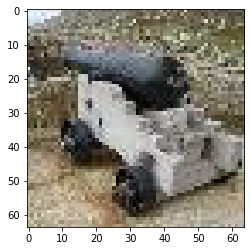

In [ ]:
print("path: ", selected_train_samples[0])
print("original train image: ")
img = Image.open(selected_train_samples[0])
plt.imshow(img)

reconstructed train image: 
/content/drive/My Drive/DL/HW2/train/n02950826/images/n02950826_295.JPEG
torch.Size([3, 224, 224])


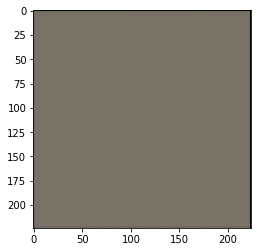

In [ ]:
print("reconstructed train image: ")
print(selected_train_samples[0])
img = conv2_decoder.test_model(selected_train_samples[0])
img = img.squeeze(0)
print(img.shape)
transform = transforms.ToPILImage()
im1 = transform(img)
plt.imshow(im1)

path:  /content/drive/My Drive/DL/HW2/train/n02950826/images/n02950826_131.JPEG
original validation image: 


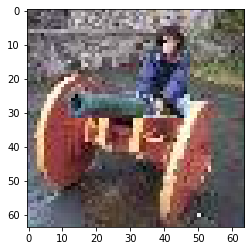

In [ ]:
print("path: ", selected_test_samples[0])
print("original validation image: ")
img = Image.open(selected_test_samples[0])
plt.imshow(img)

reconstructed validation image: 
torch.Size([3, 224, 224])


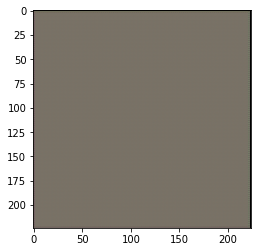

In [ ]:
print("reconstructed validation image: ")
img = conv2_decoder.test_model(selected_test_samples[0])
img = img.squeeze(0)
print(img.shape)
transform = transforms.ToPILImage()
im1 = transform(img)
plt.imshow(im1)

In [ ]:
class Conv5_Decoder(nn.Module):
  def __init__(self):
    self.learning_rate = 0.03
    self.test_loss_epoch = []
    self.train_loss_epoch = []
    
    super(Conv5_Decoder, self).__init__()

    features = list(AlexNet.features)[:13]
    self.AlexNet_Conv5 = nn.ModuleList(features).eval()

    self.conv1 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1 , padding=0)
    self.conv2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1 , padding=0)
    self.conv3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1 , padding=0)

    self.upconv1 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=5, stride=2 ,padding=2)
    self.upconv2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=5, stride=2 ,padding=1)
    self.upconv3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=5, stride=2 ,padding=1)
    self.upconv4 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=5, stride=2 ,padding=1)
    self.upconv5 = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=5, stride=2 ,padding=1)

    
  def forward(self, x):
    for i,layer in enumerate(self.AlexNet_Conv5):
      x = layer(x)
      if i == 12:
        break
    x = F.leaky_relu(self.conv1(x), negative_slope=0.2)
    x = F.leaky_relu(self.conv2(x), negative_slope=0.2)
    x = F.leaky_relu(self.conv3(x), negative_slope=0.2)
    x = F.leaky_relu(self.upconv1(x), negative_slope=0.2)
    x = F.leaky_relu(self.upconv2(x), negative_slope=0.2)
    x = F.leaky_relu(self.upconv3(x), negative_slope=0.2)
    x = F.leaky_relu(self.upconv4(x), negative_slope=0.2)
    x = F.leaky_relu(self.upconv5(x), negative_slope=0.2)

    x = F.pad(input=x, pad=(0, 1, 1, 0), mode='constant', value=0)

    return x
  def calculate_test_loss(self, paths):
    self.eval()
    loss_function = nn.MSELoss()
    test_loss = []
    with torch.no_grad():
      for i in range(len(paths)):
        image = read_image(paths[i])
        output = self(image) 
        loss = loss_function(output, image)
        test_loss.append(loss.item())
    total_loss = np.mean(test_loss)
    print("The test Loss is: ", total_loss)
    return total_loss

  def train_net(self, learning_rate, epochs, train_data):
    self.train()
    optimizer = optim.Adam(self.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    loss_function = nn.MSELoss()
    EPOCHS = epochs
    self.test_loss_epoch.append(self.calculate_test_loss(test_imagepaths))
    for epoch in range(EPOCHS):
      num = 0
      for image_path in train_data:
        data = read_image(image_path)
        optimizer.zero_grad()
        output = self(data)
        loss = loss_function(output, data)
        self.train_loss_epoch.append(loss.item())
        loss.backward()
        optimizer.step()
        num += 1
        print("epoch: ", epoch, "of batch: ", num, " batch loss: ", loss)
      self.test_loss_epoch.append(self.calculate_test_loss(test_imagepaths))
  
  def test_model(self, image_path):
    self.eval()
    with torch.no_grad():
      image = read_image(image_path)
      reconstructed_image = self.forward(image)
      return reconstructed_image

  def plot_results(self):
    plt.plot(np.arange(1,len(self.train_loss_epoch)+1), self.train_loss_epoch)
    plt.ylabel('loss of Train')
    plt.xlabel("number of steps")
    plt.grid(True)
    plt.show()
    
    plt.plot(np.arange(1,len(self.test_loss_epoch)+1), self.test_loss_epoch)
    plt.ylabel('loss of test')
    plt.xlabel("number of epochs")
    plt.grid(True)
    plt.show()


conv5_decoder = Conv5_Decoder()
conv5_decoder.train_net(0.001, 15, train_imagepaths)
conv5_decoder.plot_results()
torch.save(conv5_decoder.state_dict(), '/content/drive/My Drive/DL/HW2/conv5_decoder.pt')

<All keys matched successfully>

Streaming output truncated to the last 5000 lines.
epoch:  0 of batch:  4002  batch loss:  tensor(0.1267, grad_fn=<MseLossBackward0>)
epoch:  0 of batch:  4003  batch loss:  tensor(0.1829, grad_fn=<MseLossBackward0>)
epoch:  0 of batch:  4004  batch loss:  tensor(0.1297, grad_fn=<MseLossBackward0>)
epoch:  0 of batch:  4005  batch loss:  tensor(0.0710, grad_fn=<MseLossBackward0>)
epoch:  0 of batch:  4006  batch loss:  tensor(0.0989, grad_fn=<MseLossBackward0>)
epoch:  0 of batch:  4007  batch loss:  tensor(0.0558, grad_fn=<MseLossBackward0>)
epoch:  0 of batch:  4008  batch loss:  tensor(0.0971, grad_fn=<MseLossBackward0>)
epoch:  0 of batch:  4009  batch loss:  tensor(0.0576, grad_fn=<MseLossBackward0>)
epoch:  0 of batch:  4010  batch loss:  tensor(0.0739, grad_fn=<MseLossBackward0>)
epoch:  0 of batch:  4011  batch loss:  tensor(0.0691, grad_fn=<MseLossBackward0>)
epoch:  0 of batch:  4012  batch loss:  tensor(0.1473, grad_fn=<MseLossBackward0>)
epoch:  0 of batch:  4013  batch los

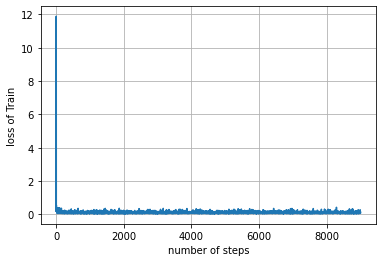

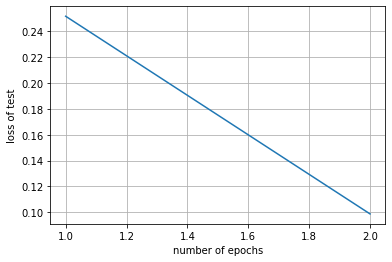

In [ ]:
class Fc6_Decoder(nn.Module):
  def __init__(self):
    self.learning_rate = 0.03
    self.test_loss_epoch = []
    self.train_loss_epoch = []
    super(Fc6_Decoder, self).__init__()
    
    self.AlexNet_conv = nn.ModuleList(list(AlexNet.features)[:]).eval()
    self.avg_pool =  AlexNet.avgpool.eval()
    self.AlexNet_FC6 = nn.ModuleList(list(AlexNet.classifier)[:3]).eval()

    self.fc1 = nn.Linear(in_features=(4096), out_features=4096)
    self.fc2 = nn.Linear(in_features=(4096), out_features=4096)
    self.fc3 = nn.Linear(in_features=(4096), out_features=4096)

    self.upconv1 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=4, stride=2 ,padding=0)
    self.upconv2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=5, stride=2 ,padding=0)
    self.upconv3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=5, stride=2 ,padding=0)
    self.upconv4 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=5, stride=2 ,padding=0)
    self.upconv5 = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=5, stride=2 ,padding=0)

  def forward(self, x):

    for i,layer in enumerate(self.AlexNet_conv):
      x = layer(x)
    x = self.avg_pool(x)
    x = x.view(-1,  1 * 1 * 9216)
    x = x.squeeze(0)
    for i,layer in enumerate(self.AlexNet_FC6):  
      x = layer(x)
      if i == 2:
        break
    x = F.leaky_relu(self.fc1(x), negative_slope=0.2)
    x = F.leaky_relu(self.fc2(x), negative_slope=0.2)
    x = F.leaky_relu(self.fc3(x), negative_slope=0.2)
    #reshaping 4096 --> 4x4x256
    x = x.view(1,256, 4 ,4)

    x = F.leaky_relu(self.upconv1(x), negative_slope=0.2)
    x = F.leaky_relu(self.upconv2(x), negative_slope=0.2)
    x = F.leaky_relu(self.upconv3(x), negative_slope=0.2)
    x = F.leaky_relu(self.upconv4(x), negative_slope=0.2)
    x = F.leaky_relu(self.upconv5(x), negative_slope=0.2)

    x = F.pad(input=x, pad=(10, 9, 9, 10), mode='constant', value=0)

    return x
  
  def calculate_test_loss(self, paths):
    self.eval()
    loss_function = nn.MSELoss()
    test_loss = []
    with torch.no_grad():
      for i in range(len(paths)):
        image = read_image(paths[i])
        output = self(image) 
        loss = loss_function(output, image)
        test_loss.append(loss.item())
    total_loss = np.mean(test_loss)
    print("The test Loss is: ", total_loss)
    return total_loss

  def train_net(self, learning_rate, epochs, train_data):
    self.train()
    optimizer = optim.Adam(self.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    loss_function = nn.MSELoss()
    EPOCHS = epochs
    self.test_loss_epoch.append(self.calculate_test_loss(test_imagepaths))
    for epoch in range(EPOCHS):
      num = 0
      for image_path in train_data:
        data = read_image(image_path)
        optimizer.zero_grad()
        output = self(data)
        loss = loss_function(output, data)
        self.train_loss_epoch.append(loss.item())
        loss.backward()
        optimizer.step()
        num += 1
        print("epoch: ", epoch, "of batch: ", num, " batch loss: ", loss)
      self.test_loss_epoch.append(self.calculate_test_loss(test_imagepaths))
  
  def test_model(self, image_path):
    self.eval()
    with torch.no_grad():
      image = read_image(image_path)
      reconstructed_image = self.forward(image)
      return reconstructed_image

  def plot_results(self):
    plt.plot(np.arange(1,len(self.train_loss_epoch)+1), self.train_loss_epoch)
    plt.ylabel('loss of Train')
    plt.xlabel("number of steps")
    plt.grid(True)
    plt.show()
    
    plt.plot(np.arange(1,len(self.test_loss_epoch)+1), self.test_loss_epoch)
    plt.ylabel('loss of test')
    plt.xlabel("number of epochs")
    plt.grid(True)
    plt.show()

fc6_decoder = Fc6_Decoder()
fc6_decoder.train_net(0.001, 1, train_imagepaths)
fc6_decoder.plot_results()
torch.save(fc6_decoder.state_dict(), '/content/drive/My Drive/DL/HW2/fc6_decoder.pt')


In [ ]:
transform2 = transforms.Compose([transforms.Resize(3), transforms.CenterCrop(224) ])
class Fc8_Decoder(nn.Module):
  def __init__(self):
    self.learning_rate = 0.03
    self.test_loss_epoch = []
    self.train_loss_epoch = []
    super(Fc8_Decoder, self).__init__()
    # self.AlexNet_FC8 = AlexNet.classifier[6]
    self.AlexNet_conv = nn.ModuleList(list(AlexNet.features)[:]).eval()
    self.avg_pool =  AlexNet.avgpool.eval()
    self.AlexNet_FC8 = nn.ModuleList(list(AlexNet.classifier)[:]).eval()

    self.fc1 = nn.Linear(in_features=(1000), out_features=4096)
    self.fc2 = nn.Linear(in_features=(4096), out_features=4096)
    self.fc3 = nn.Linear(in_features=(4096), out_features=4096)

    self.upconv1 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=5, stride=2 ,padding=0)
    self.upconv2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=5, stride=2 ,padding=0)
    self.upconv3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=5, stride=2 ,padding=0)
    self.upconv4 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=5, stride=2 ,padding=0)
    self.upconv5 = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=5, stride=2 ,padding=0)

  def forward(self, x):
    for i,layer in enumerate(self.AlexNet_conv):
      x = layer(x)
    x = self.avg_pool(x)
    x = x.view(-1,  1 * 1 * 9216)
    x = x.squeeze(0)
    for i,layer in enumerate(self.AlexNet_FC8):  
      x = layer(x)
      if i == 6:
        break

    x = F.leaky_relu(self.fc1(x), negative_slope=0.2)
    x = F.leaky_relu(self.fc2(x), negative_slope=0.2)
    x = F.leaky_relu(self.fc3(x), negative_slope=0.2)
    #reshaping 4096 --> 4x4x256
    x = x.view(1,256, 4 ,4)

    x = F.leaky_relu(self.upconv1(x), negative_slope=0.2)
    x = F.leaky_relu(self.upconv2(x), negative_slope=0.2)
    x = F.leaky_relu(self.upconv3(x), negative_slope=0.2)
    x = F.leaky_relu(self.upconv4(x), negative_slope=0.2)
    x = F.leaky_relu(self.upconv5(x), negative_slope=0.2)
    x = transform2(x)

    return x

  def calculate_test_loss(self, paths):
    self.eval()
    loss_function = nn.MSELoss()
    test_loss = []
    with torch.no_grad():
      for i in range(len(paths)):
        image = read_image(paths[i])
        output = self(image) 
        loss = loss_function(output, image)
        test_loss.append(loss.item())
    total_loss = np.mean(test_loss)
    print("The test Loss is: ", total_loss)
    return total_loss

  def train_net(self, learning_rate, epochs, train_data):
    self.train()
    optimizer = optim.Adam(self.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    loss_function = nn.MSELoss()
    EPOCHS = epochs
    self.test_loss_epoch.append(self.calculate_test_loss(test_imagepaths))
    for epoch in range(EPOCHS):
      num = 0
      for image_path in train_data:
        data = read_image(image_path)
        optimizer.zero_grad()
        output = self(data)
        loss = loss_function(output, data)
        self.train_loss_epoch.append(loss.item())
        loss.backward()
        optimizer.step()
        num += 1
        print("epoch: ", epoch, "of batch: ", num, " batch loss: ", loss)
      self.test_loss_epoch.append(self.calculate_test_loss(test_imagepaths))
  
  def test_model(self, image_path):
    self.eval()
    with torch.no_grad():
      image = read_image(image_path)
      reconstructed_image = self.forward(image)
      return reconstructed_image

  def plot_results(self):
    plt.plot(np.arange(1,len(self.train_loss_epoch)+1), self.train_loss_epoch)
    plt.ylabel('loss of Train')
    plt.xlabel("number of steps")
    plt.grid(True)
    plt.show()
    
    plt.plot(np.arange(1,len(self.test_loss_epoch)+1), self.test_loss_epoch)
    plt.ylabel('loss of test')
    plt.xlabel("number of epochs")
    plt.grid(True)
    plt.show()

fc8_decoder = Fc8_Decoder()
fc8_decoder.train_net(0.001, 1, train_imagepaths)
fc8_decoder.plot_results()
torch.save(fc8_decoder.state_dict(), '/content/drive/My Drive/DL/HW2/fc8_decoder.pt')